In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture 
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

os.environ['TF_ENABLE_ONEDNN_OPTS']='0'

from sklearn.metrics import adjusted_mutual_info_score

import os
import scipy.io

from sklearn.decomposition import PCA

2024-08-22 17:58:19.884753: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-22 17:58:19.927563: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
dataset_path = '/mnt/home/tudomlumleart/ceph/09_GastruloidDataset/GastruloidDataset/Gastruloid_72_120.mat'

In [4]:
dataset = scipy.io.loadmat(dataset_path)

In [5]:
dataset.keys()

dict_keys(['__header__', '__version__', '__globals__', 'dataset_120h_dir', 'dataset_72h_dir', 'maps_120', 'maps_72', 'polys_120', 'polys_72', 'spotData_120', 'spotData_72'])

In [44]:
gast_72_polys = dataset['polys_72']
gast_120_polys = dataset['polys_120']
gast_72_maps = dataset['maps_72']
gast_120_maps = dataset['maps_120']

In [13]:
bad_barcodes = [2, 10, 48, 57]

In [29]:
gast_72_polys[bad_barcodes, :, :] = np.NaN
gast_120_polys[bad_barcodes, :, :] = np.NaN

In [32]:
nan_frac_72 = (np.isnan(gast_72_polys[:, 1, :])).sum(axis=0)/66
nan_frac_120 = (np.isnan(gast_120_polys[:, 1, :])).sum(axis=0)/66

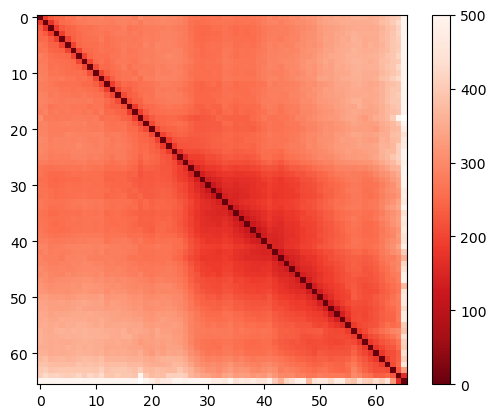

In [39]:
plt.imshow(np.nanmedian(gast_72_maps, 2), vmax=500, cmap='Reds_r')
plt.colorbar()

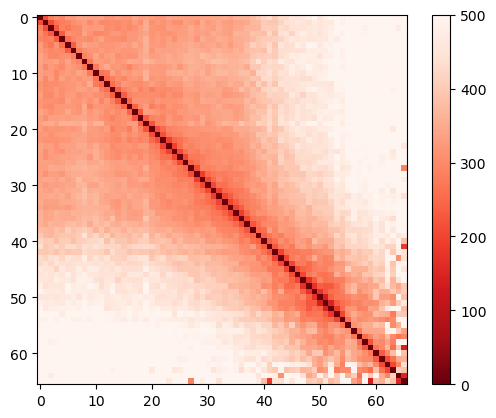

In [38]:
plt.imshow(np.nanmedian(gast_120_maps, 2), vmax=500, cmap='Reds_r')
plt.colorbar()

In [40]:
def interpolate_polymers(polys):
    num_probes, num_coords, num_cells = polys.shape
    new_polys = np.zeros((num_probes, num_coords, num_cells))
    for c in range(num_cells):
        curr_cells = polys[:, :, c]
        for x in range(num_coords):
            curr_coords = curr_cells[:, x]
            missing_indices = np.isnan(curr_coords)
            valid_indices = ~missing_indices
            interp_coords = np.interp(np.flatnonzero(missing_indices), np.flatnonzero(valid_indices), curr_coords[valid_indices])
            new_polys[missing_indices, x, c] = interp_coords
            new_polys[valid_indices, x, c] = curr_coords[valid_indices]
    return new_polys


def generate_distance_maps(polys):
    num_probes, num_coords, num_cells = polys.shape
    return np.array([squareform(pdist(polys[:, :, c])) for c in range(num_cells)])

In [45]:
gast_72_polys = interpolate_polymers(gast_72_polys[:, :, nan_frac_72<0.8])
gast_120_polys = interpolate_polymers(gast_120_polys[:, :, nan_frac_120<0.8])

gast_72_maps = generate_distance_maps(gast_72_polys)
gast_120_maps = generate_distance_maps(gast_120_polys)

In [46]:
gast_72_maps_flat = np.array([x.flatten() for x in gast_72_maps])
gast_120_maps_flat = np.array([x.flatten() for x in gast_120_maps])

In [47]:
all_maps_flat = np.concatenate([gast_72_maps_flat, gast_120_maps_flat], axis=0)

In [48]:
pca = PCA(n_components=2)
pca.fit(all_maps_flat)
gast_72_maps_pca = pca.transform(gast_72_maps_flat)
gast_120_maps_pca = pca.transform(gast_120_maps_flat)

In [51]:
gast_72_df = pd.DataFrame(gast_72_maps_pca, columns=['PC1', 'PC2'])
gast_72_df['label'] = '72 hr'
gast_120_df = pd.DataFrame(gast_120_maps_pca, columns=['PC1', 'PC2'])
gast_120_df['label'] = '120 hr'

In [52]:
all_df = pd.concat([gast_72_df, gast_120_df], axis=0)

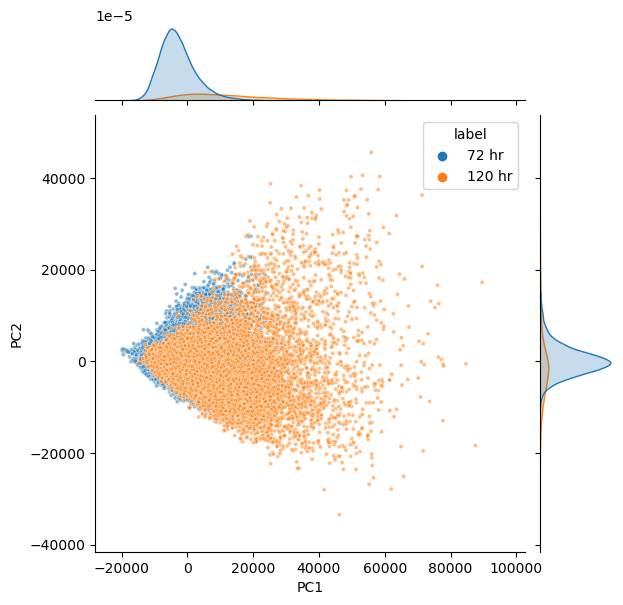

In [53]:
sns.jointplot(x='PC1', y='PC2', data=all_df, marker='.', hue='label', alpha=0.5)